In [1]:
import tensorflow as tf
import glob 

import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers as ly

from IPython import display

In [2]:
(train_X, train_y), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype("float32")
train_y = (train_X - 127.5) / 127.5 #normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60_000
BATCH_SIZE = 256

In [5]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

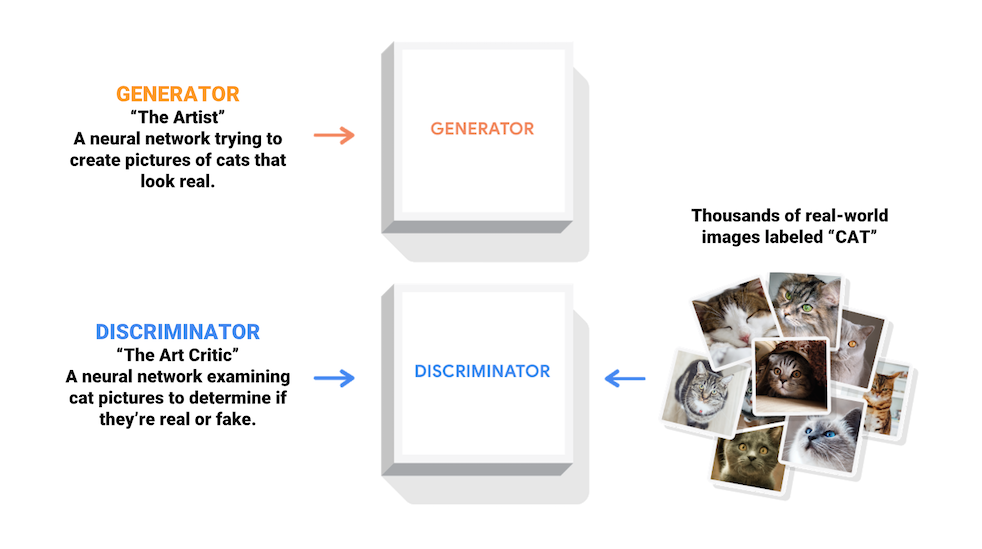

### Generator

In [6]:
def make_generator_model():
    model = tf.keras.Sequential([
        ly.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Reshape((7, 7, 256)),
        
        ly.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        ly.BatchNormalization(),
        ly.LeakyReLU(),
        
        ly.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh")
    ])
    
    return model

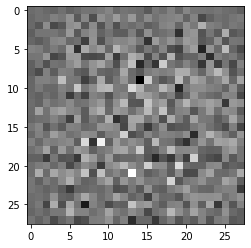

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

### Discriminator

In [22]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        ly.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
        ly.LeakyReLU(),
        ly.Dropout(0.3),
        
        ly.Conv2D(128, (5, 5), strides=(2,2), padding="same"),
        ly.LeakyReLU(),
        ly.Dropout(0.3),
        
        ly.Flatten(),
        ly.Dense(1)
    ])
    
    return model

In [25]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00192021]], shape=(1, 1), dtype=float32)


### Loss and Optimizers

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator Loss

Qualifies how well the discriminator is able to distinguish real images from fakes. It comprares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss

Qualifies how well it was able to trick the discriminatr. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).

Here , compare the discriminators decisions on the generated images to an array of 1s.

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

#### Define the training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the ttraining set) and fakes images (produced by the generator).

The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [31]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [32]:
# tf.function - this annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
        
        if (epoch+1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f"Time for epoch {epoch+1} is {time.time() - start}")
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [34]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
        
    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

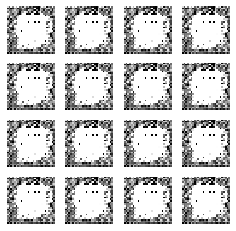

Time for epoch 31 is 36.12551760673523


KeyboardInterrupt: 

In [35]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Create a GIF

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = "dcgan.gif"

with imageio.get_writer(anim_file, mode="I") as writer:
    filenames = glob.glob("image*.png")\
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)